![image](https://www.ewatercycle.org/img/logo.png)

# Running wflow using forcing data from ESMValTool

Below are some basic steps that should get the model to work. Single catchment, single forcing dataset.
Perhaps, eventually, this can be a basic example/tutorial notebook.

More detailed information about the specific setup required to reproduce this analysis is available in the [ReadMe](https://github.com/eWaterCycle/era5-comparison/blob/master/wflow/README.md).

In [3]:
import os
import time
from datetime import datetime
import shutil
from configparser import ConfigParser
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cftime import num2date
from grpc4bmi.bmi_client_singularity import BmiClientSingularity

# Settings

In [4]:
dataset = "ERA5"
catchment = "Meuse"
PERIOD = {"start": datetime(2001, 1, 1), "end": datetime(2001, 1, 15)}

# Cartesius setup
PROJECT_HOME = Path("/projects/0/wtrcycle/comparison")
SCRATCH = Path("/scratch/shared/ewatercycle")

# relative data path to PROJECT_HOME
INPUT_DIR = PROJECT_HOME / "wflow_parameterset" / "calibrated_parameterset" / catchment.lower()
FORCING_DIR = PROJECT_HOME / "forcing" / "wflow"

In [5]:
# add a timestamped directory to the main tempdir
TEMP_DIR = SCRATCH / f"wflow_{time.strftime('%Y%m%d_%H%M%S')}"
TEMP_DIR.mkdir(parents=True, exist_ok=True)
print(TEMP_DIR)

/scratch/shared/ewatercycle/wflow_20201026_130635


## Copy input data to temp dir

In [6]:
# Time to read forcing files
start_year = PERIOD["start"].year
end_year = PERIOD["end"].year

# Find forcing from esmvaltool and copy to temp dir
forcing = glob(f"{FORCING_DIR}/wflow_{dataset}_{catchment}_{start_year}_{end_year}.nc")[0]
shutil.copy(forcing, dst=f"{TEMP_DIR}/")

# Copy config file from input dir to temp dir
config_file = f"{INPUT_DIR}/wflow_sbm_{dataset.lower()}_warmup.ini"  # reinit=1
shutil.copy(config_file, dst=f"{TEMP_DIR}/")

# Copy parameter sets from input dir to temp dir
shutil.copytree(src=INPUT_DIR / "staticmaps", dst=TEMP_DIR/"staticmaps")
shutil.copytree(src=INPUT_DIR / "intbl", dst=TEMP_DIR/"intbl")

PosixPath('/scratch/shared/ewatercycle/wflow_20201026_130635/intbl')

## Update config file

In [7]:
# Open default config file
cfg = ConfigParser()
cfg.optionxform = lambda x: x
cfg.read(f"{TEMP_DIR}/wflow_sbm_{dataset.lower()}_warmup.ini")  # reinit=1

# Modify settings
start = PERIOD["start"].strftime("%Y-%m-%d")
end = PERIOD["end"].strftime("%Y-%m-%d")
cfg.set("framework", "netcdfinput", Path(forcing).name)
cfg.set("run", "starttime", f"{start} 12:00:00 GMT")
cfg.set("run", "endtime", f"{end} 12:00:00 GMT")
cfg.set("inputmapstacks", "Precipitation", "/pr")
cfg.set("inputmapstacks", "EvapoTranspiration", "/pet")
cfg.set("inputmapstacks", "Temperature", "/tas")

# Add API fields to the config file
cfg["API"] = {
    "RiverRunoff": "2, m^3/s",
}

# Remove sections/options that break the BMI
cfg.remove_option("framework", "netcdfoutput")
cfg.remove_section("outputcsv_0")
cfg.remove_section("outputcsv_1")
cfg.remove_section("outputcsv_2")
cfg.remove_section("outputcsv_3")
cfg.remove_section("outputtss_0")

# Write to new config file
cfg_file = TEMP_DIR / f"wflow_sbm_{catchment}_{dataset}_warmup.ini"
with open(cfg_file, "w") as file:
    cfg.write(file)

In [8]:
# Workaround for missing soil maps (a dummy file, all values set to 1):
subcatch = f"{TEMP_DIR}/staticmaps/wflow_subcatch.map"
soilmap = f"{TEMP_DIR}/staticmaps/wflow_soil.map"
shutil.copy(subcatch, soilmap)

# Workaround for missing demmax and demmin
dem = f"{TEMP_DIR}/staticmaps/wflow_dem.map"
demmax = f"{TEMP_DIR}/staticmaps/wflow_demmax.map"
demmin = f"{TEMP_DIR}/staticmaps/wflow_demmin.map"
shutil.copy(dem, demmax)
shutil.copy(dem, demmin)

'/scratch/shared/ewatercycle/wflow_20201026_130635/staticmaps/wflow_demmin.map'

## Start the model inside the container

In [9]:
# Initialize the singularity container with this specific configuration
model = BmiClientSingularity(
    image="ewatercycle-wflow-grpc4bmi.sif",
    input_dir=str(TEMP_DIR)
)
model.initialize(str(cfg_file))

# Check available variables
model.get_output_var_names()

('RiverRunoff',)

## Get model fields via grpc4bmi

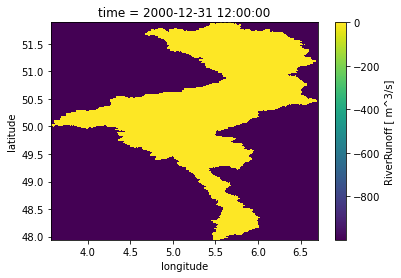

In [10]:
# Let's analyse runoff
variable = "RiverRunoff"

# Get time information
time_units = model.get_time_units()
now = num2date(model.get_current_time(), time_units)

# Get data (and convert to something that's nice in xarray)
grid = model.get_var_grid(variable)

# Get the model's internal configuration
lat = model.get_grid_x(grid)
lon = model.get_grid_y(grid)
shape = model.get_grid_shape(grid)

# Extract the data and store it in an xarray DataArray
data = np.reshape(model.get_value(variable), shape)
da = xr.DataArray(
    data,
    coords={"longitude": lon, "latitude": lat, "time": now},
    dims=["latitude", "longitude"],
    name=variable,
    attrs={"units": model.get_var_units(variable)},
)
da.plot()
plt.show()

Note that grid points outside the catchment get values of -999. We can fix this with:

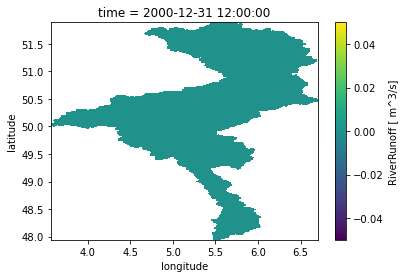

In [11]:
da.where(da != -999).plot()
plt.show()

## Run the model for a couple of time steps

In [12]:
for i in range(10):
    model.update()
    now = num2date(model.get_current_time(), time_units)
    print(now)

2001-01-01 12:00:00
2001-01-02 12:00:00
2001-01-03 12:00:00
2001-01-04 12:00:00
2001-01-05 12:00:00
2001-01-06 12:00:00
2001-01-07 12:00:00
2001-01-08 12:00:00
2001-01-09 12:00:00
2001-01-10 12:00:00


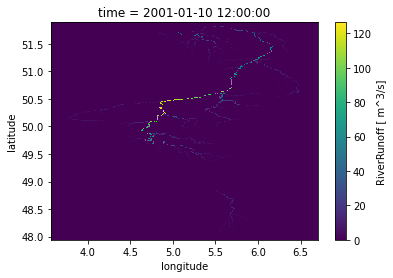

In [13]:
# Check the figure again
da.data = np.reshape(model.get_value(variable), shape)
da.time.values = num2date(model.get_current_time(), time_units)
da.where(da != -999).plot()
plt.show()

## Finalize model and stop docker

In [14]:
# Clean up the container, python env and working directory
model.finalize()
del model

## Model output
The run_default folder is created by the model in TEMP_DIR.

In [15]:
for root, dirs, files in os.walk(str(TEMP_DIR)):
    print(root)

/scratch/shared/ewatercycle/wflow_20201026_130635
/scratch/shared/ewatercycle/wflow_20201026_130635/intbl
/scratch/shared/ewatercycle/wflow_20201026_130635/run_default
/scratch/shared/ewatercycle/wflow_20201026_130635/run_default/outmaps
/scratch/shared/ewatercycle/wflow_20201026_130635/run_default/intbl
/scratch/shared/ewatercycle/wflow_20201026_130635/run_default/outsum
/scratch/shared/ewatercycle/wflow_20201026_130635/run_default/outstate
/scratch/shared/ewatercycle/wflow_20201026_130635/run_default/runinfo
/scratch/shared/ewatercycle/wflow_20201026_130635/staticmaps
/scratch/shared/ewatercycle/wflow_20201026_130635/staticmaps/clim
